Import necessary libraries and packages

In [2]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt
import cmocean.cm as cm
import gcm_filters
import zarr
import scipy.ndimage
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

%matplotlib inline

Import the data we want to handle

In [3]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [4]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
ssh = cat.LLC4320_SSH.to_dask()

/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [5]:
ds = xr.merge([sst,ssh])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
# Get data on a single face 
ds_face = xr.merge([ssh.sel(face=1), sst.sel(face=1)])

# Get coordiantes from the catalog
coords_face = (cat.LLC4320_grid.to_dask()).sel(face=1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:322: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(ifac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:324: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(jfac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.

Specify the attributes of the filter we want to apply to our datasets

In [6]:
ds_in_1 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(12000,13280), j=slice(6000,7280))

In [7]:
ds_in_2 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(0,1280), j=slice(4000,5280))

Filter the data and then compute it so we can use it 

In [8]:
smaller_datasets1_unfiltered = []
original_i_size1 = ds_in_1.to_dataset().dims['i']
original_j_size1 = ds_in_1.to_dataset().dims['j']

for i_start in range(0, original_i_size1, 128):
    for j_start in range(0, original_j_size1, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size1)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size1)   # Ensure j_end does not exceed 7279

        
        # Subset the dataset
        ds_unfiltered_subset1 = ds_in_1.isel(time=slice(0,76), i=slice(i_start, i_end), j=slice(j_start, j_end))
        ds_unfiltered_subset1 = ds_unfiltered_subset1.drop_vars(['i','j']) 
        
        # Append the subsets to the respective lists
        smaller_datasets1_unfiltered.append(ds_unfiltered_subset1)

/tmp/ipykernel_416/2755664323.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size1 = ds_in_1.to_dataset().dims['i']
/tmp/ipykernel_416/2755664323.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size1 = ds_in_1.to_dataset().dims['j']


We do the exact same thing with our second dataset

In [9]:
smaller_datasets2_unfiltered = []
original_i_size2 = ds_in_2.to_dataset().dims['i']
original_j_size2 = ds_in_2.to_dataset().dims['j']


for i_start in range(0, original_i_size2, 128):
    for j_start in range(0, original_j_size2, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size2)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size2)   # Ensure j_end does not exceed 7279

        # Subset the dataset
        ds_unfiltered_subset2 = ds_in_2.isel(time=slice(0,76), i=slice(i_start, i_end), j=slice(j_start, j_end))
        ds_unfiltered_subset2 = ds_unfiltered_subset2.drop_vars(['i','j'])
        
        # Append the subsets to the respective lists
        smaller_datasets2_unfiltered.append(ds_unfiltered_subset2)

/tmp/ipykernel_416/272578556.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size2 = ds_in_2.to_dataset().dims['i']
/tmp/ipykernel_416/272578556.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size2 = ds_in_2.to_dataset().dims['j']


In [10]:
ds1_unfiltered = xr.concat(smaller_datasets1_unfiltered, dim='datasets1')

In [11]:
ds2_unfiltered = xr.concat(smaller_datasets2_unfiltered, dim='datasets2')

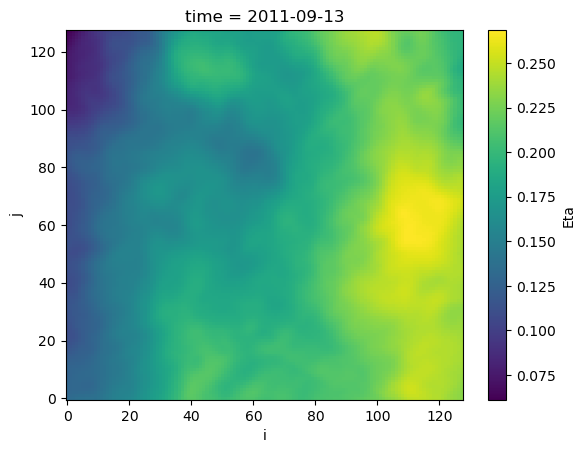

In [63]:
ds1_unfiltered.isel(datasets1=0).isel(time=0).plot()

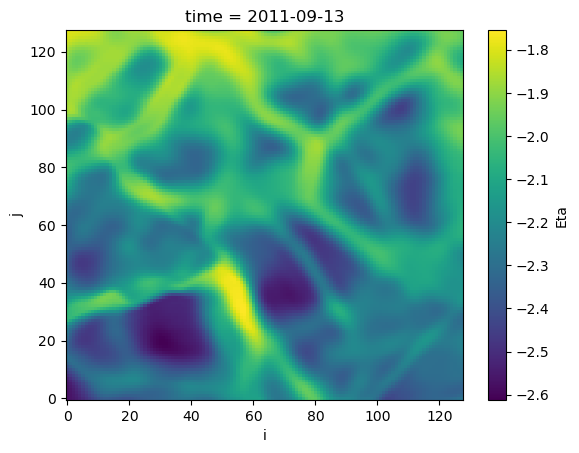

In [43]:
ds2_unfiltered.isel(datasets2=0).isel(time=0).plot()

Now we convert the filtered and unfiltered lists for each dataset into DataArray objects for easier storage and access

In [44]:
def downscale_block(block, factor):
    if block.ndim == 3:
        zoomed = scipy.ndimage.zoom(block, (1, factor, factor), order=3)
        new_coords = {
            'time': np.arange(76),
            'j': np.arange(16),
            'i': np.arange(16)
        }
        return xr.DataArray(zoomed, dims=['time', 'j', 'i'], coords=new_coords)
    else:
        raise ValueError("Block needs to have three dimensions (time, j, i)")
ds2_unfiltered = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds2_unfiltered_128.zarr",
    engine="zarr",
    chunks={'dataset2_large': 1, 'time': 10, 'j': 64, 'i': 64}
)
ds2_downscaled = []
for k in range(100):
    ds2_unfiltered_0 = ds2_unfiltered.Eta.isel(dataset2_large=k)
    downscaled = downscale_block(ds2_unfiltered_0, factor=0.125)
    ds2_downscaled.append(downscaled.values)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "i" starting at index 64. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [48]:
def downscale_block(block, factor):
    if block.ndim == 3:
        zoomed = scipy.ndimage.zoom(block, (1, factor, factor), order=3)
        new_coords = {
            'time': np.arange(76),
            'j': np.arange(16),
            'i': np.arange(16)
        }
        return xr.DataArray(zoomed, dims=['time', 'j', 'i'], coords=new_coords)
    else:
        raise ValueError("Block needs to have three dimensions (time, j, i)")
ds1_unfiltered = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds1_unfiltered_128.zarr",
    engine="zarr",
    chunks={'dataset1_large': 1, 'time': 10, 'j': 64, 'i': 64}
)
ds1_downscaled = []
for k in range(100):
    ds1_unfiltered_0 = ds1_unfiltered.Eta.isel(dataset1_large=k)
    downscaled = downscale_block(ds1_unfiltered_0, factor=0.125)
    ds1_downscaled.append(downscaled.values)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "j" starting at index 64. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [45]:
dims = ['dataset2_filt','time','j','i']
coords = {
    'dataset2_filt': np.arange(100),
    'time': np.arange(76),
    'j': np.arange(16),
    'i': np.arange(16)
}

ds2_filtered = xr.DataArray(ds2_downscaled, dims=dims, coords=coords)

In [49]:
dims = ['dataset1_filt','time','j','i']
coords = {
    'dataset1_filt': np.arange(100),
    'time': np.arange(76),
    'j': np.arange(16),
    'i': np.arange(16)
}

ds1_filtered = xr.DataArray(ds1_downscaled, dims=dims, coords=coords)

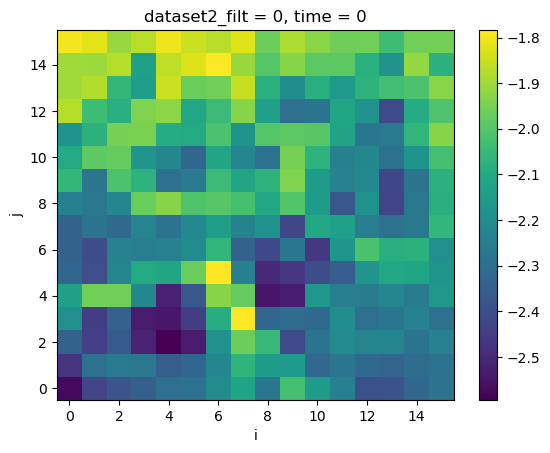

In [47]:
ds2_filtered.isel(dataset2_filt=0).isel(time=0).plot()

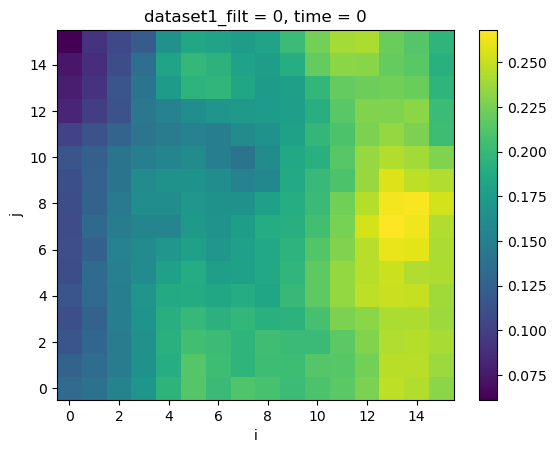

In [50]:
ds1_filtered.isel(dataset1_filt=0).isel(time=0).plot()

In [52]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds1_downscale.zarr"
ds1_filtered.to_zarr(f"{user_path}/{store_name}")

In [53]:
store_name = "ds2_downscale.zarr"
ds2_filtered.to_zarr(f"{user_path}/{store_name}")

In [69]:
store_name = "ds1_norm.zarr"
ds1_unfiltered.to_zarr(f"{user_path}/{store_name}")

In [16]:
user_path = "gs://leap-persistent/funky-user"
store_name = "ds2_normal.zarr"
ds2_unfiltered.to_zarr(f"{user_path}/{store_name}")

In [17]:
dataset = xr.open_zarr('gs://leap-persistent/funky-user/ds2_normal.zarr')